In [1]:
# Here is a classical max cut QAOA inspired from:
#  https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained
#  https://qiskit.org/textbook/ch-applications/qaoa.html
#  https://lucaman99.github.io/new_blog/2020/mar16.html

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt

In [36]:
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [37]:
from scipy.optimize import minimize

Number of nodes :  5
Nodes colors: 
 ['r', 'r', 'r', 'r', 'r']
Weight matrix: 
 [[0. 1. 7. 1. 0.]
 [1. 0. 9. 5. 0.]
 [7. 9. 0. 3. 1.]
 [1. 5. 3. 0. 1.]
 [0. 0. 1. 1. 0.]]
#######################################################################################


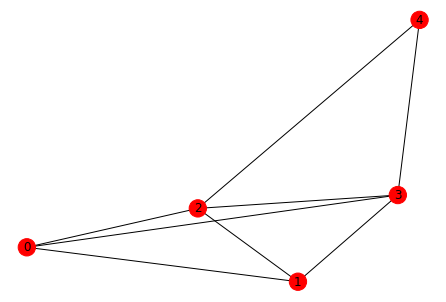

In [38]:
# First let's build some usefull function to creat Graphs and color them:

class Graph:
    
    def __init__(self,nr_nodes, edge_list):
        self.edge_list=edge_list
        self.nr_nodes=nr_nodes
        self.colors=['r' for i in range(nr_nodes)]
        self.G=self.Graph() 
        self.W=self.WeightMatrix()

        
        
    def Graph(self):
        G=nx.Graph()
        G.add_nodes_from(np.arange(0,self.nr_nodes,1))
        G.add_weighted_edges_from(self.edge_list)
        return G
    
    def  WeightMatrix(self):
        W=np.zeros([self.nr_nodes,self.nr_nodes])
        for i in range (self.nr_nodes):
            for j in range(self.nr_nodes):
                temp=self.G.get_edge_data(i,j,default=0)
                if temp!=0:
                    W[i,j]=temp['weight']
        return W
        
        
    
elist=[(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]#[(0,1,1.0),(1,2,1.0),(2,3,1.0)]
G1=Graph(5,elist)

print("Number of nodes : ",G1.nr_nodes)
print("Nodes colors: \n",G1.colors)
print("Weight matrix: \n",G1.W)
print("#######################################################################################")
nx.draw(G1.G,node_color=G1.colors,with_labels=True)

In [39]:
#brut force  for verification  :
def brut_MaxCut(Gr):
    best_cost_brute=0
    max_str=[]
    maxim=0
    for b in range(2**Gr.nr_nodes):
        x=[int(t) for t in reversed(list(bin(b)[2:].zfill(Gr.nr_nodes)))]
        cost=0
        for i in range(Gr.nr_nodes):
            for j in range(Gr.nr_nodes):
                cost=cost+Gr.W[i,j]*x[i]*(1-x[j])

        
        if best_cost_brute==cost:
            max_str.append(str(x))
            
        if best_cost_brute<cost:
            best_cost_brute=cost
            max_str=[]
            max_str.append(str(x))
 
            
    return  max_str, best_cost_brute
            
        
max_str, best_cost= brut_MaxCut(G1)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)
    

Best cut (cost=24.0): 
 
[0, 0, 1, 1, 0]
[1, 1, 0, 0, 1]


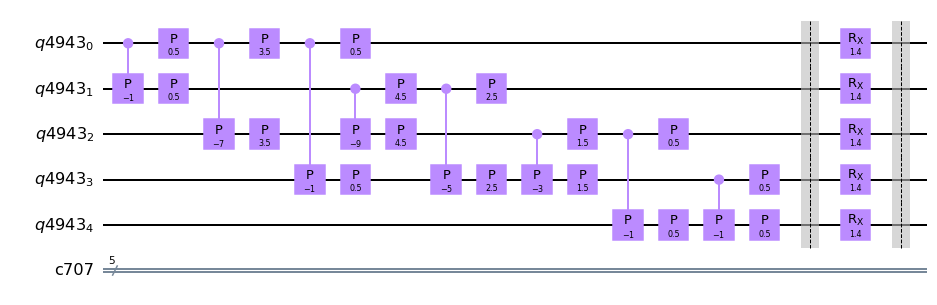

In [40]:
Gr=G1

nrq=G1.nr_nodes

qr=QuantumRegister(nrq)
cr=ClassicalRegister(nrq)
qc=QuantumCircuit(qr,cr)



def HC_01(qc,qr,gamma,W):
    
    W=W*gamma
    for i in range(len(qr)):
        for j in range(i+1,len(qr)):
            if W[i][j]!=0:
                qc.cp(-2*W[i,j],qr[i],qr[j])
                qc.p(W[i,j],qr[i])
                qc.p(W[i,j],qr[j])
                
    qc.barrier()

def HB_01(qc,qr,beta):
    
    for i in range(len(qr)):
        qc.rx(2*beta,qr[i])
    qc.barrier()

HC_01(qc,qr,0.5,G1.W)
HB_01(qc,qr,0.7)

qc.draw('mpl')

In [41]:
def Init_H(qc,qr,list=[]):
    for i in range(int(len(qr))):
        qc.h(qr[i])
    qc.barrier()

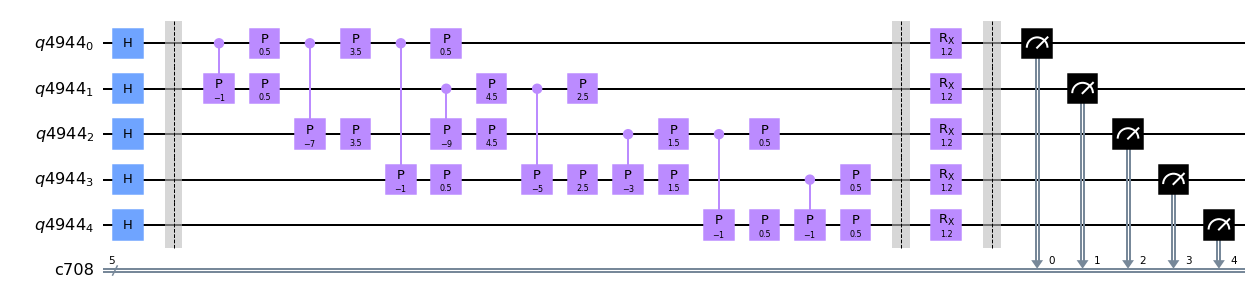

In [42]:
def QAOA_circ_01(Gr,params,l=1):
    
    qr=QuantumRegister(Gr.nr_nodes)
    cr=ClassicalRegister(Gr.nr_nodes)
    qc_QAOA=QuantumCircuit(qr,cr)
    
    Init_H(qc_QAOA,qr)
    for i in range(l):
        HC_01(qc_QAOA,qr,params[i*2],Gr.W)
        HB_01(qc_QAOA,qr,params[i*2+1])
    
    for i in range(Gr.nr_nodes):
        qc_QAOA.measure(qr[i],cr[i])
    return qc_QAOA

QAOA_circ=QAOA_circ_01(G1,[0.5,0.6],l=1)
QAOA_circ.draw('mpl')  

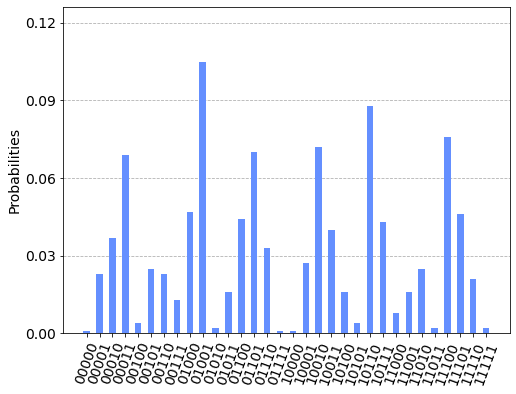

In [43]:
backend=Aer.get_backend("qasm_simulator")
shots=1000

simulate=execute(QAOA_circ, backend=backend, shots=shots)
counts=simulate.result().get_counts()
plot_histogram(counts,figsize = (8,6),bar_labels = False)

In [44]:
def expected_01(counts,Gr,shots):
    cost=0
    for x in counts:
        for i in range (Gr.nr_nodes):
            for j in range(i+1,Gr.nr_nodes):
                if x[i]!=x[j]:
                    cost=cost-Gr.W[i][j]*counts[x]
    cost=cost/shots
    return cost

cost=expected_01(counts,G1,shots)
print(cost)

-14.607


In [45]:
def QAOA_cost(params,Gr,l=1,
              backend=Aer.get_backend("qasm_simulator"),shots=1000):
    
    qc_QAOA=QAOA_circ_01(Gr,params,l=1)
    counts=execute(qc_QAOA, backend=backend, shots=shots).result().get_counts()
    cost=expected_01(counts,Gr,shots)
    return cost

cost=QAOA_cost([0.5,0.3],Gr,l=1,
                backend=Aer.get_backend("qasm_simulator"),shots=1000)
print(cost)

-13.871


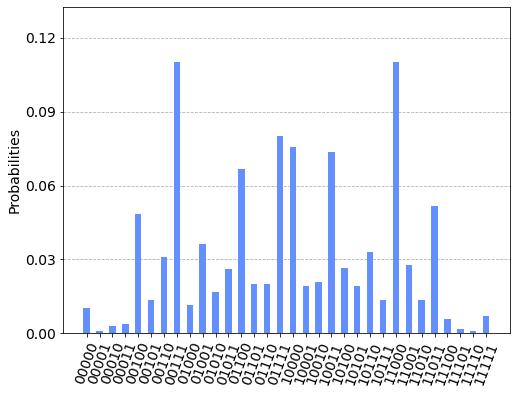

In [46]:
def MaxCut_01(G1,l,params=[0.5,0.3,0.5,0.3],nr_s=2,shots=5000):
    
    optim=minimize(QAOA_cost, params ,args=(G1,l),method='COBYLA', 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 
                            'disp': True, 'catol': 0.0002})
    QAOA_circ=QAOA_circ_01(G1,optim.x,l=l)
    counts=execute(QAOA_circ, backend=backend, shots=shots).result().get_counts()
    counts=dict(reversed(sorted(counts.items(), key=lambda item: item[1])))
    
    o=0
    sol=[]
    for i in counts:
        sol.append((i[::-1],counts[i]))
        if len(sol)==nr_s:
            break
            
    return counts,sol

counts, sol = MaxCut_01(G1,l=1)
plot_histogram(counts,figsize = (8,6),bar_labels = False)

In [47]:
counts

{'00111': 552,
 '11000': 552,
 '01111': 400,
 '10000': 378,
 '10011': 369,
 '01100': 334,
 '11011': 259,
 '00100': 242,
 '01001': 182,
 '10110': 165,
 '00110': 155,
 '11001': 138,
 '10100': 132,
 '01011': 131,
 '10010': 104,
 '01110': 101,
 '01101': 100,
 '10101': 96,
 '10001': 96,
 '01010': 83,
 '00101': 68,
 '11010': 68,
 '10111': 68,
 '01000': 58,
 '00000': 52,
 '11111': 36,
 '11100': 29,
 '00011': 19,
 '00010': 15,
 '11101': 9,
 '11110': 5,
 '00001': 4}

In [54]:
print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(G1)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)

QAOA solutions:
('01101', 326)
('10010', 306)

 Clasic solutions:
Best cut (cost=24.0): 
- [0, 0, 1, 1, 0]
- [1, 1, 0, 0, 1]


In [55]:
elist=[(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]#[(0,1,1.0),(1,2,1.0),(2,3,1.0)]
G2=Graph(5,elist)

counts, sol = MaxCut_01(G2,l=1,shots=5000)

print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(G2)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)

QAOA solutions:
('10101', 293)
('01010', 276)

 Clasic solutions:
Best cut (cost=24.0): 
- [0, 0, 1, 1, 0]
- [1, 1, 0, 0, 1]


In [56]:
elist=[(6,0,9.0),(0,1,3.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]#[(0,1,1.0),(1,2,1.0),(2,3,1.0)]
G3=Graph(6,elist)

counts, sol = MaxCut_01(G3,l=1,nr_s=4,shots=5000)

print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(G3)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)

QAOA solutions:
('111001', 243)
('111000', 241)
('000110', 239)
('000111', 236)

 Clasic solutions:
Best cut (cost=24.0): 
- [0, 0, 1, 1, 0, 0]
- [1, 1, 0, 0, 1, 0]
- [0, 0, 1, 1, 0, 1]
- [1, 1, 0, 0, 1, 1]
